In [1]:
## Notebook contains:
## Unsupervised learning techniques to detect fraud 
## Segment customers using K-means clustering algorithm to detect suspicious occurrences in our data

In [65]:
## Installation of plotly 
# pip install plotly
# OR
# conda install -c plotly plotly

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import sys
import datetime 
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from sklearn.manifold import TSNE
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [3]:
banksim_df = pd.read_csv("banksim.csv")
banksim_df.head()

Unnamed: 0 age gender           category  amount  fraud
0      171915   3      F  es_transportation   49.71      0
1      426989   4      F          es_health   39.29      0
2      310539   3      F  es_transportation   18.76      0
3      215216   4      M  es_transportation   13.95      0
4      569244   2      M  es_transportation   49.87      0

In [4]:
banksim_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
banksim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7200 non-null   object 
 1   gender    7200 non-null   object 
 2   category  7200 non-null   object 
 3   amount    7200 non-null   float64
 4   fraud     7200 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 281.4+ KB


The raw dataset has 7200 records and 5 features out of which three are categorical and rest are numerical.

In [6]:
banksim_adj_df = pd.read_csv("banksim_adj.csv")
banksim_adj_df.head()

Unnamed: 0  age  amount  fraud  M  es_barsandrestaurants  es_contents  \
0           0    3   49.71      0  0                      0            0   
1           1    4   39.29      0  0                      0            0   
2           2    3   18.76      0  0                      0            0   
3           3    4   13.95      0  1                      0            0   
4           4    2   49.87      0  1                      0            0   

   es_fashion  es_food  es_health  es_home  es_hotelservices  es_hyper  \
0           0        0          0        0                 0         0   
1           0        0          1        0                 0         0   
2           0        0          0        0                 0         0   
3           0        0          0        0                 0         0   
4           0        0          0        0                 0         0   

   es_leisure  es_otherservices  es_sportsandtoys  es_tech  es_transportation  \
0           0                 0                 0        0                  1   
1           0                 0                 0        0                  0   
2           0                 0                 0        0                  1   
3           0                 0                 0        0                  1   
4           0                 0                 0        0                  1   

   es_travel  
0          0  
1          0  
2          0  
3          0  
4          0

In [7]:
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
# dataframe details
banksim_adj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    7189 non-null   int64  
 1   amount                 7189 non-null   float64
 2   fraud                  7189 non-null   int64  
 3   M                      7189 non-null   int64  
 4   es_barsandrestaurants  7189 non-null   int64  
 5   es_contents            7189 non-null   int64  
 6   es_fashion             7189 non-null   int64  
 7   es_food                7189 non-null   int64  
 8   es_health              7189 non-null   int64  
 9   es_home                7189 non-null   int64  
 10  es_hotelservices       7189 non-null   int64  
 11  es_hyper               7189 non-null   int64  
 12  es_leisure             7189 non-null   int64  
 13  es_otherservices       7189 non-null   int64  
 14  es_sportsandtoys       7189 non-null   int64  
 15  es_t

- Over 7000 records with 17 encoded features are present
- This is a pre-processed version of the raw dataset

In [9]:
# analyzing average fraud transaction amount for each category
banksim_df.groupby(['category']).mean()

amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_wellnessandbeauty    66.167078  0.060606

Majority of fraudulent activity is observed in "leisure", "travel" and "sportsandtoys" related transactions.

In [10]:
# analyzing average fraud transaction amount for each age category
banksim_adj_df.groupby(['age'])['amount','fraud'].mean()

amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293

In [11]:
banksim_adj_df['age'].value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
Name: age, dtype: int64

- **The average amount spent as well as fraud occurrence is rather similar across groups**
- **Age group '0' stands out but since there are only 2452 instances it would not make much difference to split these into age segments**

In [12]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

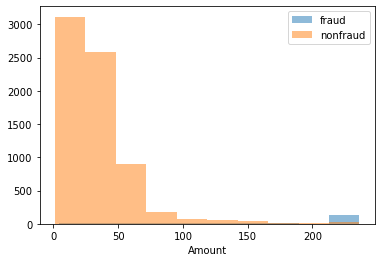

In [13]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('Amount')
plt.legend()
plt.show()

Fraudulent transactions tend to be on the larger side relative to normal observations which helps us in distinguishing fraud from non-fraud.

In [14]:
# fraud vs. normal transactions 
counts = banksim_adj_df.fraud.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('There are {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

There are 6989 non-fraudulent transactions (97.218%) and 200 fraudulent transactions (2.782%).


Text(0.5, 0, 'Class (0:Non-Fraudulent, 1:Fraudulent)')

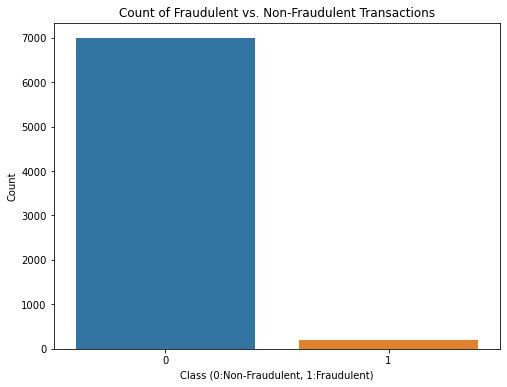

In [15]:
## visualizing class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class (0:Non-Fraudulent, 1:Fraudulent)')

In [16]:
# separating input features and target variable
X = banksim_adj_df.drop('fraud', axis=1, )
Y = banksim_adj_df['fraud']

In [17]:
# Transform and scale your input data
X = np.array(X).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### KMeans Clustering



- The objective of any clustering model is to detect patterns in the data, more specifically to group the data into distinct clusters made of data points that are very similar to each other, but distinct from the points in the other clusters.
- A very commonly used clustering algorithm is K-means clustering. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. 
- The objective of k-means is to minimize the sum of all distances between the data samples and their associated cluster centroids.
- It involves a random centroid initialization followed by cluster assignment and centroid calculation that are executed iteratively until a stable mean set is arrived upon.

- **Cluster Assignment: Assign each data point to one of the two clusters based on its distance from them. A point is assigned to the cluster, whose centroid it is closer to.**

- **Move Centroid: After cluster assignment, centroids are moved to the mean of clusters formed. And then the process is repeated. After a certain number of steps the centroids will no longer move around and then the iterations can stop.**

![title](https://dashee87.github.io/images/kmeans.gif)

In [18]:
#Choosing the range for 'k' in order to select its optimal value
SSE = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=23)
    kmeans.fit_predict(X_scaled)
    SSE[k] = kmeans.inertia_


#### Scree Plot

- Visualization of number of clusters against inertia, that is sum of distances of samples to their closest cluster center.
- Elbow method is used to determine the optimal number of clusters and the user must look for a change of slope from steep to shallow (an elbow) to determine the optimal number of clusters.

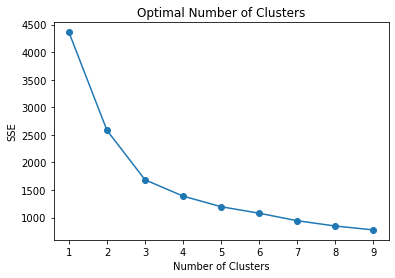

In [19]:
#Plotting cluster against SSE
plt.figure()
plt.plot(list(SSE.keys()), list(SSE.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Optimal Number of Clusters")
plt.show()

The optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve

#### Silhouette Score

- Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

Silhouette Score = (b-a)/max(a,b)

where,

a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.

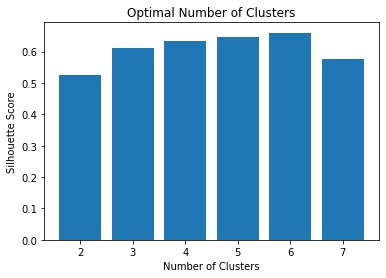

In [20]:
#Calculating and plotting silhouette scores for number of clusters ranging from 2-7
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_scaled, KMeans(n_clusters = n_cluster).fit_predict(X_scaled))) 
    
# Plotting a bar graph to compare the results 
k = range(2,8)
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Silhouette Score')
plt.title("Optimal Number of Clusters")
plt.show()

- k=6 has the highest silhouette score as observed from the plot above
- We may proceed with clustering with both k=3 (as per elbow method) as well as k=6 (as per silhouette scores)

In [21]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=0)

In [22]:
# Define K-means model with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(x_train)

### Assigning Fraud vs. Non-Fraud

- Take the outliers of each cluster, and flag those as fraud

- Collect and store the cluster centroids in memory
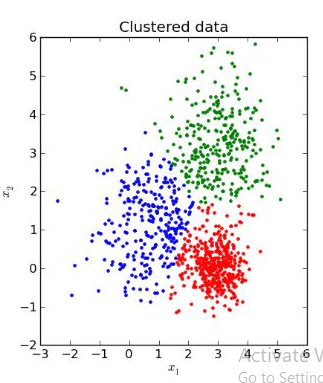

- Calculate the distance of each point in the dataset, to their own cluster centroid


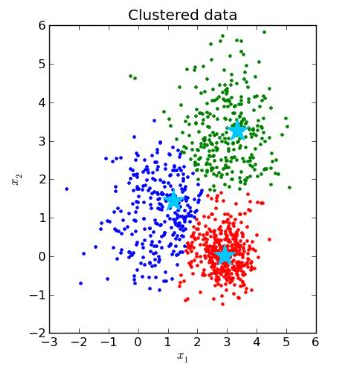

- Define a cut-off point for the distances to define what's an outlier
     - based on the distributions of the distances collected, i.e., everything with a distance larger than the top 95th percentile, should be considered an outlier

Note: Euclidean distance is depicted by the circles in the fig below and any sample point outside the yellow circles is considered an outlier

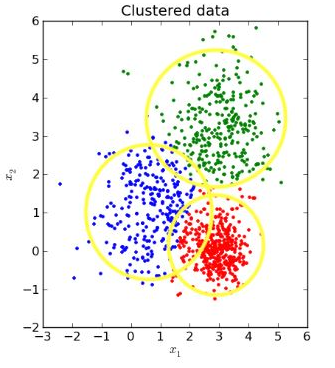

In [23]:
# Obtain predictions and calculate distance from cluster centroid
clusters_km_3 = kmeans_3.predict(x_test)
clusters_km_3_centers = kmeans_3.cluster_centers_
dist_km_3 = [np.linalg.norm(x-y) for x, y in zip(x_test, clusters_km_3_centers[clusters_km_3])]

In [24]:
# Create fraud predictions based on outliers on clusters 
y_pred_km_3 = np.array(dist_km_3)
y_pred_km_3[dist_km_3 >= np.percentile(dist_km_3, 95)] = 1
y_pred_km_3[dist_km_3 < np.percentile(dist_km_3, 95)] = 0

In [25]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


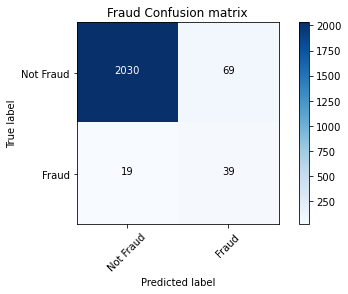

In [26]:
# Create a confusion matrix
cm_km_3 = confusion_matrix(y_test, y_pred_km_3)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(cm_km_3)

KMeans cluster model precisely identified 39 out of 58 fraud transactions

In [27]:
# Obtain the ROC score
roc_auc_score(y_test, y_pred_km_3)

0.8197704982668266

In [28]:
# Define K-means model with 6 clusters
kmeans_6 = KMeans(n_clusters=6, random_state=42).fit(x_train)

In [29]:
# Obtain predictions and calculate distance from cluster centroid
clusters_km_6 = kmeans_6.predict(x_test)
clusters_km_6_centers = kmeans_6.cluster_centers_
dist_km_6 = [np.linalg.norm(x-y) for x, y in zip(x_test, clusters_km_6_centers[clusters_km_6])]

In [30]:
# Create fraud predictions based on outliers on clusters 
y_pred_km_6 = np.array(dist_km_6)
y_pred_km_6[dist_km_6 >= np.percentile(dist_km_6, 95)] = 1
y_pred_km_6[dist_km_6 < np.percentile(dist_km_6, 95)] = 0

Confusion matrix, without normalization


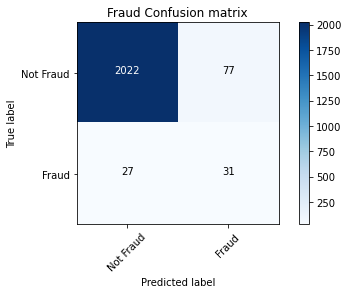

In [31]:
# Create a confusion matrix
cm_km_6 = confusion_matrix(y_test, y_pred_km_6)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(cm_km_6)

With 6 clusters, the false positives are high and true fraud predictions are less in comparison to the 3 cluster case

In [32]:
# Obtain the ROC score
roc_auc_score(y_test, y_pred_km_6)

0.7488993116590823

**KMeans with three clusters is performing better than the one with six clusters in fraud detection**

In [33]:
# Training the kmeans model with k=3 on entire dataset
kmeans_final = KMeans(n_clusters=3, random_state=42).fit(X_scaled)

In [34]:
# Get the cluster number for each datapoint
X_clusters = kmeans_final.predict(X_scaled)

In [35]:
# Save the cluster centroids
X_clusters_centers = kmeans_final.cluster_centers_

In [36]:
# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

In [37]:
# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 95)] = 1
km_y_pred[dist<np.percentile(dist, 95)] = 0

In [38]:
# Converting prediction array to dataframe
y_pred_df = pd.DataFrame(km_y_pred, columns=['predicted fraud'])
y_pred_df.reset_index(drop=True, inplace=True)

In [39]:
banksim_adj_df.reset_index(drop=True, inplace=True)
final_df = pd.concat([banksim_adj_df,y_pred_df], axis=1)

In [40]:
final_df.head()

age  amount  fraud  M  es_barsandrestaurants  es_contents  es_fashion  \
0    3   49.71      0  0                      0            0           0   
1    4   39.29      0  0                      0            0           0   
2    3   18.76      0  0                      0            0           0   
3    4   13.95      0  1                      0            0           0   
4    2   49.87      0  1                      0            0           0   

   es_food  es_health  es_home  es_hotelservices  es_hyper  es_leisure  \
0        0          0        0                 0         0           0   
1        0          1        0                 0         0           0   
2        0          0        0                 0         0           0   
3        0          0        0                 0         0           0   
4        0          0        0                 0         0           0   

   es_otherservices  es_sportsandtoys  es_tech  es_transportation  es_travel  \
0                 0                 0        0                  1          0   
1                 0                 0        0                  0          0   
2                 0                 0        0                  1          0   
3                 0                 0        0                  1          0   
4                 0                 0        0                  1          0   

   predicted fraud  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

In [41]:
final_df.drop('fraud', axis=1, inplace=True)

In [42]:
final_df['predicted fraud'] = final_df['predicted fraud'].astype(int)

In [43]:
final_df.head()

age  amount  M  es_barsandrestaurants  es_contents  es_fashion  es_food  \
0    3   49.71  0                      0            0           0        0   
1    4   39.29  0                      0            0           0        0   
2    3   18.76  0                      0            0           0        0   
3    4   13.95  1                      0            0           0        0   
4    2   49.87  1                      0            0           0        0   

   es_health  es_home  es_hotelservices  es_hyper  es_leisure  \
0          0        0                 0         0           0   
1          1        0                 0         0           0   
2          0        0                 0         0           0   
3          0        0                 0         0           0   
4          0        0                 0         0           0   

   es_otherservices  es_sportsandtoys  es_tech  es_transportation  es_travel  \
0                 0                 0        0                  1          0   
1                 0                 0        0                  0          0   
2                 0                 0        0                  1          0   
3                 0                 0        0                  1          0   
4                 0                 0        0                  1          0   

   predicted fraud  
0                0  
1                0  
2                0  
3                0  
4                0

In [44]:
final_df.groupby('predicted fraud')['amount'].mean()

predicted fraud
0     31.663774
1    137.792288
Name: amount, dtype: float64

The average transaction amount in fraudulent cases are approximately 4.35 times more than in the legit cases

#### t-SNE

- t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique used to visualize and explore high-dimensional data, introduced by van der Maaten and Hinton in 2008. 
- t-SNE creates a 2-D visual representation of multi-dimensional data while preserving local similarities and spacial relationships between data points in their original, higher dimensionality. Essentially, it can help us understand how data is distributed and arranged in high-dimensional space.

In [62]:
X_embedded = TSNE(n_components=2).fit_transform(X_scaled)
final_df["x_component"] = X_embedded[:,0]
final_df["y_component"] = X_embedded[:,1]

##### Components needed for cluster visualization
- X axis of plot = x component identified by t-SNE (“x_component”)
- Y axis of plot = y component identified by t-SNE (“y_component”)
- Color of each data point = cluster label identified by KMeans (“predicted fraud”)

In [63]:
# Kmeans cluster visualization
fig = px.scatter(final_df, x="x_component", y="y_component", color = "predicted fraud", size_max=60)
fig.update_layout(height=800)
fig.show()

### DBSCAN - Density-Based Spatial Clustering of Applications with Noise

- The number of clusters does not need to be predefined
- The algorithm finds core samples of high density and expands clusters from them
- Works well on data containing clusters of similar density
- This type of algorithm can be used to identify fraud as very small clusters
- Maximum allowed distance between points in a cluster must be assigned
- Minimal number of data points in clusters must be assigned
- Better performance on non-convex data than K-means 
- Computationally heavier than K-means

- Density-Based Clustering refers to unsupervised learning methods that identify distinctive groups/clusters in the data, based on the idea that a cluster in data space is a contiguous region of high point density, separated from other such clusters by contiguous regions of low point density.
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a base algorithm for density-based clustering. It can discover clusters of different shapes and sizes from a large amount of data, which is containing noise and outliers.

***The DBSCAN algorithm uses two parameters:***

- minPts: The minimum number of points (a threshold) clustered together for a region to be considered dense.minPoints is the minimum number of data points required inside that circle for that data point to be classified as a Core point.
- eps (ε): A distance measure that will be used to locate the points in the neighborhood of any point. Epsilon is the radius of the circle to be created around each data point to check the density

***These parameters can be understood if we explore two concepts called Density Reachability and Density Connectivity.***


- Reachability in terms of density establishes a point to be reachable from another if it lies within a particular distance (eps) from it.

- Connectivity, on the other hand, involves a transitivity based chaining-approach to determine whether points are located in a particular cluster. For example, p and q points could be connected if p->r->s->t->q, where a->b means b is in the neighborhood of a.

***There are three types of points after the DBSCAN clustering is complete:***
![title](https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png)


- Core — This is a point that has at least m points within distance n from itself.
- Border — This is a point that has at least one Core point at a distance n.
- Noise — This is a point that is neither a Core nor a Border. And it has less than m points within distance n from itself.


#### Algorithmic Steps for DBSCAN Clustering

- The algorithm proceeds by arbitrarily picking up a point in the dataset (until all points have been visited).
- If there are at least ‘minPoint’ points within a radius of ‘ε’ to the point then we consider all these points to be part of the same cluster.
- The clusters are then expanded by recursively repeating the neighborhood calculation for each neighboring point
![title](https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif)

#### Step - 1

- Start by defining the epsilon parameter which is the distance between data points allowed from which the cluster expands
- Define minimum samples in the clusters
- Fit DBSCAN to scaled data

In [46]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

#### Step - 2

- Use labels_ method to get the assigned cluster label for each data point
- The cluster count can also be determine by counting the unique cluster labels from the cluster label_ predictions

In [47]:
# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in Y else 0)

In [48]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(Y, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


The number of clusters is much higher than with K-means.

#### Assessing Smallest Clusters
 
Flagging certain clusters as fraud involves the following steps:
- Examine how big the clusters are and filter out the smallest
- Filter out the smallest ones and flag those as fraud
- Compare the predicted labels with the original ones to evaluate fraud detection performance

In [49]:
# Count the samples within each cluster by running a bincount on the predicted cluster numbers under pred_labels 
counts = np.bincount(pred_labels[pred_labels >= 0])
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [50]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [51]:
# Print the sample counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


So now we know which smallest clusters could be flagged as fraud. If we were to take more of the smallest clusters, we can cast our net wider and catch more fraud, but most likely more false positives as well.

### Results Verification

- Assess the results of DBscan fraud detection model. 
- In reality, we often don't have reliable labels and this is where a fraud analyst pitches in to help validate the results. They can analyse whether the cases which were flagged are indeed suspicious or not. 
- Also, comparison with historically known cases of fraud may be carried out and analyse whether the model flags them or not.

In [52]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
dbscan_pred_df = pd.DataFrame({'cluster no.':pred_labels,'fraud':Y})

In [53]:
# Create a condition flagging fraud for the smallest clusters 
dbscan_pred_df['predicted fraud'] = np.where((dbscan_pred_df['cluster no.'].isin([21, 17, 9])), 1 , 0)

In [54]:
# Create a crosstab from the actual fraud labels with the newly created predicted fraud labels 
dbscan_results = pd.crosstab(dbscan_pred_df['fraud'], dbscan_pred_df['predicted fraud'],\
                             rownames=['Actual Fraud'], colnames=['Flagged Fraud'])
dbscan_results

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24

Out of all flagged cases, roughly 2/3 are actually fraud! 

Since we take only the three smallest clusters, by definition you flag less cases of fraud, so you catch less but also have less false positives. 

In [55]:
# Merging the predicted dbscan labels with original dataframe
dbscan_pred_df.reset_index(drop=True, inplace=True)
banksim_adj_df.reset_index(drop=True, inplace=True)
df_final = pd.concat([banksim_adj_df,dbscan_pred_df], axis=1)

In [56]:
df_final.head()

age  amount  fraud  M  es_barsandrestaurants  es_contents  es_fashion  \
0    3   49.71      0  0                      0            0           0   
1    4   39.29      0  0                      0            0           0   
2    3   18.76      0  0                      0            0           0   
3    4   13.95      0  1                      0            0           0   
4    2   49.87      0  1                      0            0           0   

   es_food  es_health  es_home  ...  es_hyper  es_leisure  es_otherservices  \
0        0          0        0  ...         0           0                 0   
1        0          1        0  ...         0           0                 0   
2        0          0        0  ...         0           0                 0   
3        0          0        0  ...         0           0                 0   
4        0          0        0  ...         0           0                 0   

   es_sportsandtoys  es_tech  es_transportation  es_travel  cluster no.  \
0                 0        0                  1          0            0   
1                 0        0                  0          0            1   
2                 0        0                  1          0            0   
3                 0        0                  1          0            2   
4                 0        0                  1          0            2   

   fraud  predicted fraud  
0      0                0  
1      0                0  
2      0                0  
3      0                0  
4      0                0  

[5 rows x 21 columns]

In [57]:
df_final.drop('fraud', axis=1, inplace=True)

In [58]:
X_embedded = TSNE(n_components=2).fit_transform(X_scaled)
df_final["x_component"] = X_embedded[:,0]
df_final["y_component"] = X_embedded[:,1]

In [61]:
# dbscan cluster visualization
fig = px.scatter(df_final, x="x_component", y="y_component", color = "predicted fraud", size_max=60)
fig.update_layout(height=800)
fig.show()

In [64]:
### end of notebook